In [1]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Embedding, LSTM
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import to_categorical
import numpy as np
from matplotlib import pyplot as plt

DATASET:

https://www.kaggle.com/amananandrai/ag-news-classification-dataset?select=train.csv

Load dataset

In [2]:
ag_train = pd.read_csv('train.csv') 

In [3]:
ag_train.shape

(120000, 3)

Pre-processing data

In [4]:
data = ag_train['Title'] + ' ' + ag_train['Description']
data = data.values

In [5]:
clean_text = []

for i in data:
  teks = i.replace("\\", " ")
  clean_text.append(teks)

clean_text = np.asarray(clean_text)

In [6]:
cat = ag_train['Class Index'].values
new_cat = [i-1 for i in cat]
new_cat = to_categorical(new_cat)

Split data to train and validation

In [7]:
x_train, x_val, y_train, y_val = train_test_split(clean_text, new_cat, test_size=0.2, random_state=4)

print(x_train.shape, x_val.shape, y_train.shape, y_val.shape)

(96000,) (24000,) (96000, 4) (24000, 4)


Tokenizing and sequencing data

In [8]:
tokenizer = Tokenizer(num_words=5000, oov_token='-')

tokenizer.fit_on_texts(x_train)
tokenizer.fit_on_texts(x_val)

seq_train = tokenizer.texts_to_sequences(x_train)
seq_val = tokenizer.texts_to_sequences(x_val)

padded_train = pad_sequences(seq_train)
padded_val = pad_sequences(seq_val)

Build a model

In [9]:
model = Sequential()

model.add(Embedding(input_dim=10000, output_dim=128))
model.add(LSTM(256))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(4, activation='softmax'))

adam = tf.keras.optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, amsgrad=False)

model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

callback = EarlyStopping(monitor='val_accuracy', patience = 2)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         1280000   
_________________________________________________________________
lstm (LSTM)                  (None, 256)               394240    
_________________________________________________________________
dense (Dense)                (None, 256)               65792     
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8

Train the model

In [10]:
hist = model.fit(padded_train, y_train,
                 batch_size=300, epochs=10,
                 validation_data=(padded_val, y_val),
                 callbacks=[callback],
                 verbose=1)

Epoch 1/10
320/320 [==============================] - 24s 75ms/step - loss: 0.5743 - accuracy: 0.7819 - val_loss: 0.3305 - val_accuracy: 0.8901
Epoch 2/10
320/320 [==============================] - 24s 75ms/step - loss: 0.2964 - accuracy: 0.9035 - val_loss: 0.2929 - val_accuracy: 0.9044
Epoch 3/10
320/320 [==============================] - 24s 75ms/step - loss: 0.2439 - accuracy: 0.9193 - val_loss: 0.2757 - val_accuracy: 0.9052
Epoch 4/10
320/320 [==============================] - 24s 75ms/step - loss: 0.2146 - accuracy: 0.9282 - val_loss: 0.2980 - val_accuracy: 0.9015
Epoch 5/10
320/320 [==============================] - 24s 75ms/step - loss: 0.1920 - accuracy: 0.9349 - val_loss: 0.3018 - val_accuracy: 0.9013


Plotting accuracy and loss of the model

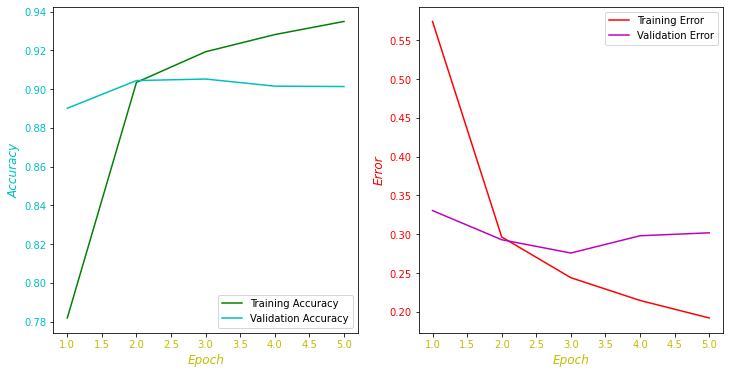

In [11]:
n = len(hist.history['loss']) + 1
ep = np.arange(1, n, 1)

fig, ax = plt.subplots(1, 2, figsize=(12,6))

ax[0].set_xlabel('Epoch', style='italic', size=12, color='y')
ax[0].set_ylabel('Accuracy', style='italic', size = 12, color = 'c')
ax[0].plot(ep, hist.history['accuracy'], color = 'g')
ax[0].plot(ep, hist.history['val_accuracy'], color = 'c')
ax[0].tick_params(axis='x', labelcolor='y')
ax[0].tick_params(axis='y', labelcolor='c')
ax[0].legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')

ax[1].set_xlabel('Epoch', style='italic', size=12, color='y')
ax[1].set_ylabel('Error', style = 'italic', size = 12, color = 'r')
ax[1].plot(ep, hist.history['loss'], color = 'r')
ax[1].plot(ep, hist.history['val_loss'], color = 'm')
ax[1].tick_params(axis='x', labelcolor='y')
ax[1].tick_params(axis='y', labelcolor='r')
ax[1].legend(['Training Error', 'Validation Error'], loc='upper right')

Referensi:

https://www.kaggle.com/amananandrai/news-article-classifier-with-different-models
https://www.kaggle.com/amananandrai/news-article-multiclass-classifier
https://medium.com/@djajafer/multi-class-text-classification-with-keras-and-lstm-4c5525bef592
https://medium.com/@robert.salgado/multiclass-text-classification-from-start-to-finish-f616a8642538
https://towardsdatascience.com/multi-class-text-classification-model-comparison-and-selection-5eb066197568
https://keras.io/api/callbacks/early_stopping/